<a href="https://colab.research.google.com/github/anggaagustiratelkom/IoT-Step-Counting/blob/main/IoT_Step_Counting_(Sensor_Accelerometer_Phypox).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
import pandas as pd
import random 
import math
from scipy import signal
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [216]:
!ls "drive/My Drive/Tugas_IoT/berjalan.xlsx"
df1 = pd.read_excel('/content/drive/My Drive/Tugas_IoT/berjalan.xlsx')


'drive/My Drive/Tugas_IoT/berjalan.xlsx'


In [217]:
accel_time = df1["Time (s)"]
accelx = df1["Acceleration x (m/s^2)"]
accely = df1["Acceleration y (m/s^2)"]
accelz = df1["Acceleration z (m/s^2)"]
accel_mag = np.sqrt(accelx**2 + accely**2 + accelz**2)
sample_time_in_ms = (accel_time[accel_time.size - 1] * 1000) - (accel_time[0] * 1000)
sample_time_in_s = sample_time_in_ms / 1000
# print("Length (raw diff): {} secs".format(sample_time_in_ms))
print("Num samples: ", accel_time.size)
print("First timestamp: {} ms".format(int(accel_time[0] * 1000)))
print("Last timestamp: {} ms".format(int(accel_time[accel_time.size-1] * 1000)))

# # Dive into timestamps a bit to analyze sampling rate over time
map_sec_to_sample_count = dict()
for timestamp_ms in accel_time:
    sec_floor = math.floor(timestamp_ms)
    if sec_floor not in map_sec_to_sample_count:
        map_sec_to_sample_count[sec_floor] = 0
    map_sec_to_sample_count[sec_floor] = map_sec_to_sample_count[sec_floor] + 1

print("Length (raw diff): {} secs".format(sample_time_in_s))
print("Length (rounded ceiling): {} secs".format(len(map_sec_to_sample_count)))

counts = list(map_sec_to_sample_count.values())
np_counts = np.array(counts)
sampling_rate_imprecise = accel_time.size / sample_time_in_s
print("Coarse sampling rate: {:.2f} samples/sec".format(sampling_rate_imprecise))
sampling_rate = np.average(np_counts)
print("More precise sampling rate calc: {:.2f} samples/sec (SD={:.2f} samples/sec)".
      format(sampling_rate, np.std(np_counts)))

print()
print("**Accel stats**")
print("Avg x: {:.2f} (SD={:.2f})".format(np.mean(accelx), np.std(accelx)))
print("Avg y: {:.2f} (SD={:.2f})".format(np.mean(accely), np.std(accely)))
print("Avg z: {:.2f} (SD={:.2f})".format(np.mean(accelz), np.std(accelz)))
print("Avg mag: {:.2f} (SD={:.2f})".format(np.mean(accel_mag), np.std(accel_mag)))

Num samples:  1399
First timestamp: 41 ms
Last timestamp: 46930 ms
Length (raw diff): 46.889739407 secs
Length (rounded ceiling): 47 secs
Coarse sampling rate: 29.84 samples/sec
More precise sampling rate calc: 29.77 samples/sec (SD=0.47 samples/sec)

**Accel stats**
Avg x: 1.90 (SD=3.20)
Avg y: 9.58 (SD=2.11)
Avg z: -2.17 (SD=2.27)
Avg mag: 10.66 (SD=2.51)


In [218]:
df = pd.DataFrame(list(zip(accel_time, accelx, accely, accelz,)), 
               columns =["Time", "X", "Y", "Z"]) 

df.describe()

,Time,X,Y,Z
count,1399.000000,1399.000000,1399.000000,1399.000000
mean,23.478869,1.897204,9.582918,-2.167610
std,13.550098,3.198488,2.110114,2.266182
min,0.041039,-19.515139,2.533065,-16.579847
25%,11.757530,0.596156,8.947132,-3.380613
50%,23.473938,1.812411,9.411607,-2.444480
75%,35.200094,3.478775,10.352528,-0.949301
max,46.930778,12.729970,23.017855,14.693215


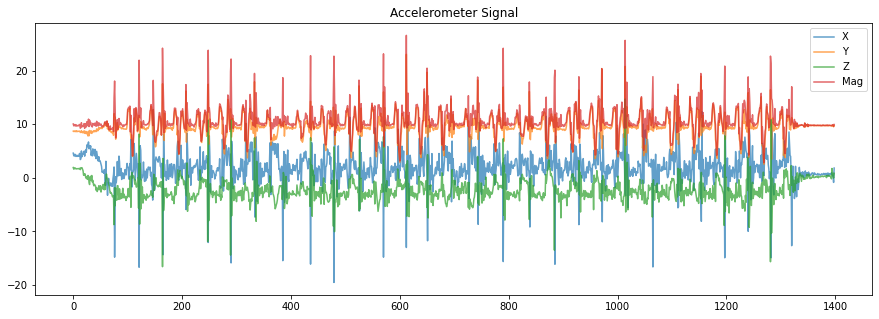

In [219]:
# Now, let's plot the raw x, y, z, and magnitude values
fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height
axes.plot(accelx, alpha=0.7, label="X")
axes.plot(accely, alpha=0.7, label="Y")
axes.plot(accelz, alpha=0.7, label="Z")
axes.plot(accel_mag, alpha=0.7, label="Mag")

# set the title and show the legend
axes.set_title("Accelerometer Signal")
axes.legend()

# What do you observe?

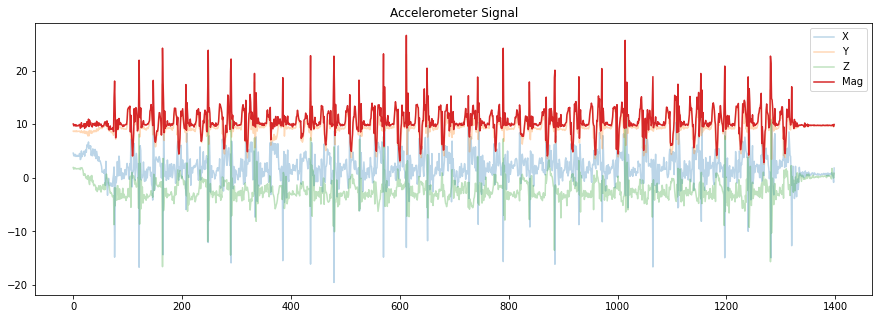

In [220]:
fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height
axes.plot(accelx, alpha=0.3, label="X")
axes.plot(accely, alpha=0.3, label="Y")
axes.plot(accelz, alpha=0.3, label="Z")
axes.plot(accel_mag, alpha=1, label="Mag")

# set the title and show the legend
axes.set_title("Accelerometer Signal")
axes.legend()

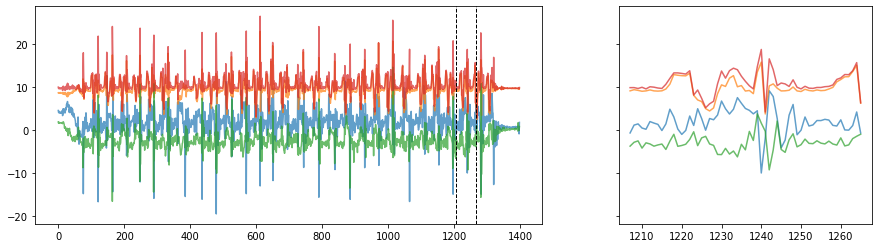

In [221]:
n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]}, sharey='all')
axes[0].plot(accelx, alpha=0.7, label="X")
axes[0].plot(accely, alpha=0.7, label="Y")
axes[0].plot(accelz, alpha=0.7, label="Z")
axes[0].plot(accel_mag, alpha=0.7, label="Mag")

# show a zoomed in view of ~10 periods
zoom_window_secs = 2
zoom_samples = math.floor(sampling_rate * zoom_window_secs)
zoom_start_index = random.randint(0, len(accelx) - zoom_samples)
zoom_end_index = zoom_start_index + zoom_samples
zoom_x = list(range(zoom_start_index, zoom_end_index))

axes[1].plot(zoom_x, accelx[zoom_start_index : zoom_end_index], alpha=0.7, label="X")
axes[1].plot(zoom_x, accely[zoom_start_index : zoom_end_index], alpha=0.7, label="Y")
axes[1].plot(zoom_x, accelz[zoom_start_index : zoom_end_index], alpha=0.7, label="Z")
axes[1].plot(zoom_x, accel_mag[zoom_start_index : zoom_end_index], alpha=0.7, label="Mag")

# highlight where this zoomed view is occurring on main plot
axes[0].axvline(zoom_start_index, linestyle="dashed", linewidth=1, color="black")
axes[0].axvline(zoom_end_index, linestyle="dashed", linewidth=1, color="black")

In [222]:
# fourier transformations and frequency-based features
num_samples = len(accel_mag)

# the mean substraction removes the y offset before performing FFT
fft = np.abs(np.fft.fft(accel_mag - np.mean(accel_mag)))
freqs = np.fft.fftfreq(len(fft))
freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

print("We have {} frequency bins of size {}Hz from {} to {}Hz".\
      format(len(freqs), (freqs[1]-freqs[0]), freqs[0], np.abs(freqs[num_samples//2])))
freqs = freqs[range(num_samples//2)] # one side freq range, integer division
abs_fft = np.abs(fft)[range(num_samples//2)] # one side freq range, integer division
abs_fft_normalized = abs_fft / num_samples # normalize to values 0 - 1

# find the max frequency
max_freq_idx = np.argmax(abs_fft_normalized)
max_freq = freqs[max_freq_idx]
print("The max frequency is: {} Hz".format(max_freq))

top_n_freq = 3
ind = np.argpartition(abs_fft_normalized, -top_n_freq)[-top_n_freq:] # from https://stackoverflow.com/a/23734295
ind_sorted_by_coef = ind[np.argsort(-abs_fft_normalized[ind])] # reverse sort indices

# I appear to walk at ~1.6 Hz :)
print("Top 3 frequencies (freq, coef):", list(zip(freqs[ind_sorted_by_coef], abs_fft_normalized[ind_sorted_by_coef]))) # print top freq
top1_freq = freqs[ind_sorted_by_coef][0]
top2_freq = freqs[ind_sorted_by_coef][0]
top3_freq = freqs[ind_sorted_by_coef][0]

We have 1399 frequency bins of size 0.02127659574468085Hz from 0.0 to 14.872340425531915Hz
The max frequency is: 1.3191489361702127 Hz
Top 3 frequencies (freq, coef): [(1.3191489361702127, 0.31208501307565434), (1.4042553191489362, 0.3057332705474188), (1.3829787234042554, 0.27764650734147317)]


Sampling rate: 29.77 Hz
Maximum detectable frequency in our signal is: 14.88 Hz (due to Nyquist theorem)


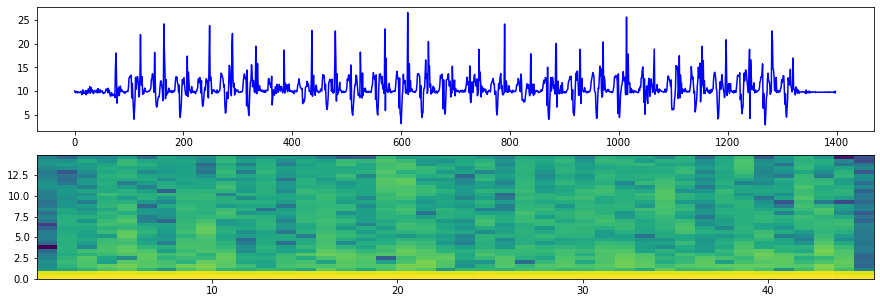

In [223]:
print("Sampling rate: {:0.2f} Hz".format(sampling_rate))
print("Maximum detectable frequency in our signal is: {:.2f} Hz (due to Nyquist theorem)".format(sampling_rate/2.0))

NFFT = 64       # the length of the windowing segments
fig, (axes1, axes2) = plt.subplots(2, 1, figsize=(15, 5)) # create two rows, one col of plots

axes1.plot(accel_mag, 'b-', label="netMag Accel")
Pxx, freqs, bins, im = axes2.specgram(accel_mag, NFFT=NFFT, Fs=sampling_rate, noverlap=math.ceil(NFFT/2.0))

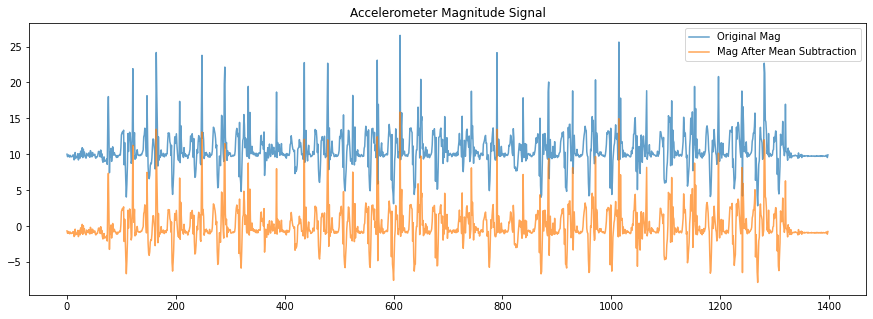

In [224]:
# Apply some basic processing. Here, we'll subtract out the mean so that the
# average of the signal is zero (this is helpful to, for example, count zero crossings)

mag_after_mean_subtraction = accel_mag - np.average(accel_mag)

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_after_mean_subtraction, alpha=0.7, label="Mag After Mean Subtraction")

# set the title and show the legend
axes.set_title("Accelerometer Magnitude Signal")
axes.legend()

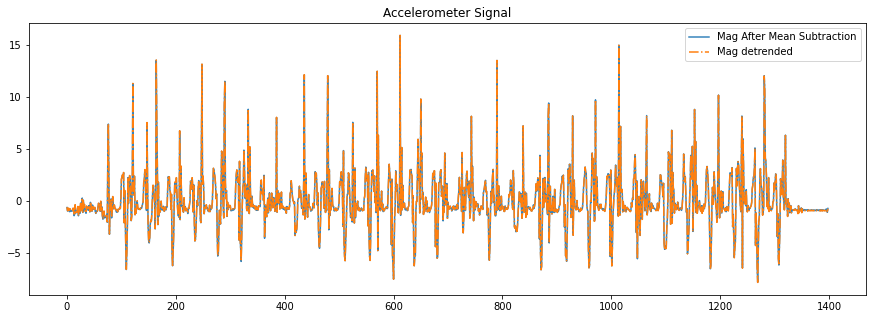

In [225]:
# We can also use scipy's built in detrend algorithm, which is the result
# of a linear least-squares fit to the data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
mag_detrended = sp.signal.detrend(accel_mag) 

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_after_mean_subtraction, alpha=0.9, label="Mag After Mean Subtraction")
axes.plot(mag_detrended, alpha=1, linestyle="-.", label="Mag detrended")

# set the title and show the legend
axes.set_title("Accelerometer Signal")
axes.legend()

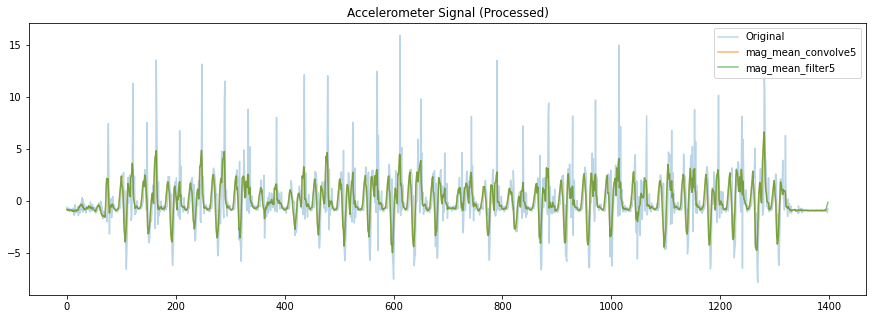

In [226]:
# Now, let's play around with various smoothing methods
# Here are different mean smoothing filters
# Note that the filter window size should really be a function of your sampling rate

def mean_filter(signal, N):
    filter_signal = np.zeros((len(signal),))
    for ctr in range(len(signal)):
         filter_signal[ctr] = np.sum(signal[ctr:(ctr+N)])
    return filter_signal/N


filter_window_size = 5

# Convolve using a mean filter
# https://numpy.org/doc/stable/reference/generated/numpy.convolve.html?highlight=convolve#numpy.convolve
# or just use our own mean_filter code
mag_mean_convolve5 = np.convolve(mag_detrended, 
                           np.ones((filter_window_size,))/filter_window_size, 
                           mode='valid')


mag_mean_filter5 = mean_filter(mag_detrended, filter_window_size)

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_detrended, alpha=0.3, label="Original")
axes.plot(mag_mean_convolve5, alpha=0.6, label="mag_mean_convolve5")
axes.plot(mag_mean_filter5, alpha=0.6, label="mag_mean_filter5")

# set the title and show the legend
axes.set_title("Accelerometer Signal (Processed)")
axes.legend()

6.6057244749197706


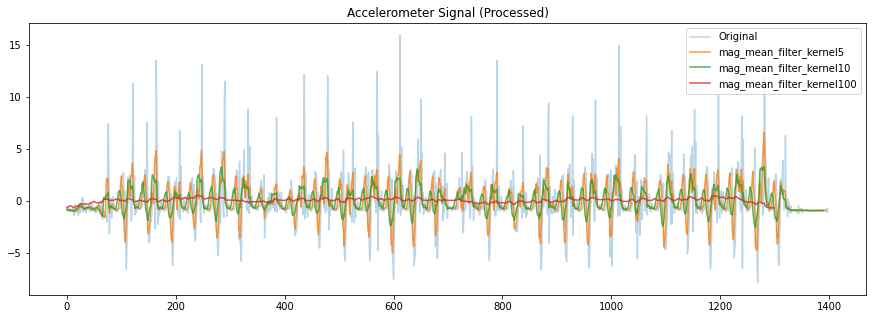

In [227]:
# Effect of various window sizes on mean filter

filter_window_size = 5

# Convolve using a mean filter
# https://numpy.org/doc/stable/reference/generated/numpy.convolve.html?highlight=convolve#numpy.convolve
# or just use our own mean_filter code
mag_mean_filter_kernel5 = np.convolve(mag_detrended, 
                           np.ones((filter_window_size,))/filter_window_size, 
                           mode='valid')

filter_window_size = 10
mag_mean_filter_kernel10 = np.convolve(mag_detrended, 
                           np.ones((filter_window_size,))/filter_window_size, 
                           mode='valid')

filter_window_size = 100
mag_mean_filter_kernel100 = np.convolve(mag_detrended, 
                           np.ones((filter_window_size,))/filter_window_size, 
                           mode='valid')

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_detrended, alpha=0.3, label="Original")
axes.plot(mag_mean_filter_kernel5, alpha=0.8, label="mag_mean_filter_kernel5")
axes.plot(mag_mean_filter_kernel10, alpha=0.8, label="mag_mean_filter_kernel10")
axes.plot(mag_mean_filter_kernel100, alpha=0.8, label="mag_mean_filter_kernel100")

# set the title and show the legend
axes.set_title("Accelerometer Signal (Processed)")
axes.legend()
print(max(mag_mean_filter_kernel5))

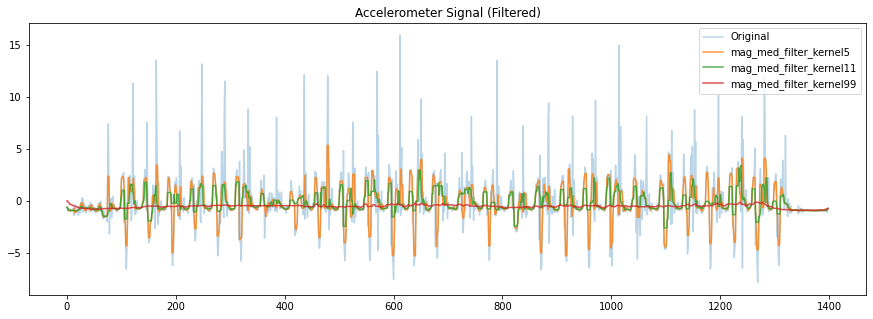

In [228]:
# median filters are easy to implement but fairly destructive
filter_window_size = 5 # should be odd
mag_med_filter_kernel5 = sp.signal.medfilt(mag_detrended, filter_window_size)

filter_window_size = 11
mag_med_filter_kernel11 = sp.signal.medfilt(mag_detrended, filter_window_size)

filter_window_size = 99
mag_med_filter_kernel99 = sp.signal.medfilt(mag_detrended, filter_window_size)

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_detrended, alpha=0.3, label="Original")
axes.plot(mag_med_filter_kernel5, alpha=0.8, label="mag_med_filter_kernel5")
axes.plot(mag_med_filter_kernel11, alpha=0.8, label="mag_med_filter_kernel11")
axes.plot(mag_med_filter_kernel99, alpha=0.8, label="mag_med_filter_kernel99")

# set the title and show the legend
axes.set_title("Accelerometer Signal (Filtered)")
axes.legend()

Sampling rate: 29.77 Hz
Maximum detectable frequency in our signal is: 14.88 Hz (due to Nyquist theorem)


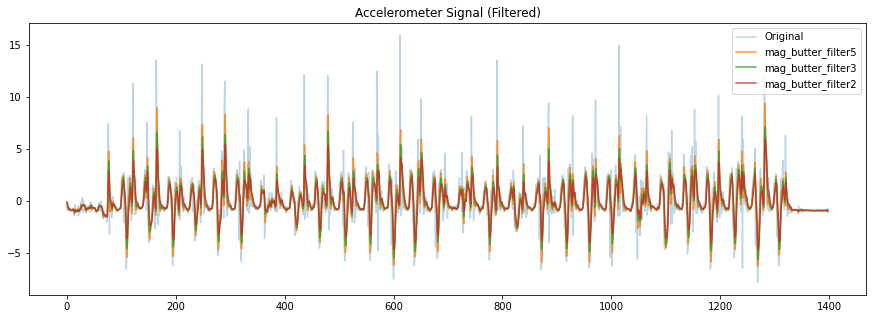

In [249]:
print("Sampling rate: {:0.2f} Hz".format(sampling_rate))
print("Maximum detectable frequency in our signal is: {:.2f} Hz (due to Nyquist theorem)".format(sampling_rate/2.0))

filter_order = 1
low_pass_cutoff_freq = 5;
nyquist_freq = 0.5 * sampling_rate
sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
mag_butter_filter5 = signal.sosfilt(sos, mag_detrended)

low_pass_cutoff_freq = 3;
sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
mag_butter_filter3 = signal.sosfilt(sos, mag_detrended)

low_pass_cutoff_freq = 2;
sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
mag_butter_filter2 = signal.sosfilt(sos, mag_detrended)

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height

# axes.plot(accel_mag, alpha=0.7, label="Original Mag")
axes.plot(mag_detrended, alpha=0.3, label="Original")
axes.plot(mag_butter_filter5, alpha=0.8, label="mag_butter_filter5")
axes.plot(mag_butter_filter3, alpha=0.8, label="mag_butter_filter3")
axes.plot(mag_butter_filter2, alpha=0.8, label="mag_butter_filter2")

# set the title and show the legend
axes.set_title("Accelerometer Signal (Filtered)")
axes.legend()

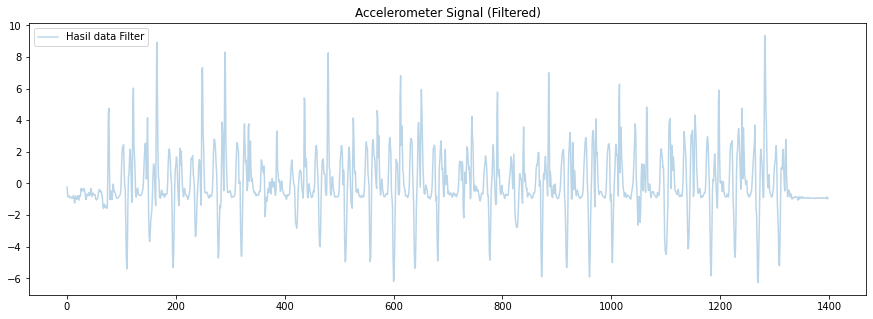

In [248]:
magNoG = accel_mag - accel_mag.mean();

fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height
axes.plot(mag_butter_filter5, alpha=0.3, label="Hasil data Filter")
axes.set_title("Accelerometer Signal (Filtered)")
axes.legend()

In [231]:
minPeakHeight = accel_mag.std();
print(minPeakHeight)

2.508907044779837


No handles with labels found to put in legend.


28


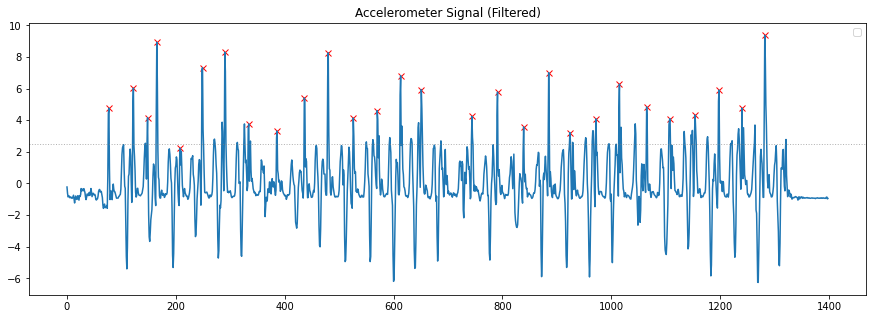

In [243]:
from scipy.signal import find_peaks, find_peaks_cwt
peaks, _ = find_peaks(mag_butter_filter5, prominence=minPeakHeight*2)
print(len(peaks))
# jumlah = peaks.count()
# print(jumllah)
fig, axes = plt.subplots(1, figsize=(15, 5)) #figsize is width, height
plt.plot(peaks, mag_butter_filter5[peaks], "xr"); plt.plot(mag_butter_filter5); plt.legend(['distance'])
axes.axhline(minPeakHeight, linewidth=1, linestyle=":", alpha=0.6, color='gray')
axes.set_title("Accelerometer Signal (Filtered)")
axes.legend()


In [246]:
rata2_langkah = 30
langkah = (len(peaks))
jalan = langkah*2
jarak = jalan*rata2_langkah
print(jarak, "cm")
print("Jarak +- : ", jarak/100, "Meter")


1680 cm
Jarak +- :  16.8 Meter
